## 초기 setting

In [1]:
from google import colab

colab.drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
data_path = '/content/drive/Shareddrives/JobCare/Jobcare_data/'
submit_path = '/content/drive/Shareddrives/JobCare/submit/'
SEED = 42

In [3]:
import os
import sys
import platform
import random
import math
from typing import List ,Dict, Tuple

import pandas as pd
import numpy as np
 
import sklearn 
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score 

In [4]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [5]:
train_data = pd.read_csv(f'{data_path}train.csv')
test_data = pd.read_csv(f'{data_path}test.csv')

code_d = pd.read_csv(f'{data_path}속성_D_코드.csv')
code_h = pd.read_csv(f'{data_path}속성_H_코드.csv')
code_l = pd.read_csv(f'{data_path}속성_L_코드.csv')

train_data.shape , test_data.shape

((501951, 35), (46404, 34))

In [6]:
code_d.columns= ["attribute_d","attribute_d_d","attribute_d_s","attribute_d_m","attribute_d_l"]
code_h.columns= ["attribute_h","attribute_h_p","attribute_h_l"]
code_l.columns= ["attribute_l","attribute_l_d","attribute_l_s","attribute_l_m","attribute_l_l"]

In [7]:
#데이터 merge
def merge_codes(df:pd.DataFrame,df_code:pd.DataFrame,col:str)->pd.DataFrame:
    df = df.copy()
    df_code = df_code.copy()
    df_code = df_code.add_prefix(f"{col}_")
    df_code.columns.values[0] = col
    return pd.merge(df,df_code,how="left",on=col)

In [8]:
def preprocess_data(
                    df:pd.DataFrame,is_train:bool = True, cols_merge:List[Tuple[str,pd.DataFrame]] = []  , cols_equi:List[Tuple[str,str]]= [] ,
                    cols_drop:List[str] = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt"]
                    )->Tuple[pd.DataFrame,np.ndarray]:
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    for col, df_code in cols_merge:
        df = merge_codes(df,df_code,col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    return (df , y_data)

In [9]:
# 소분류 중분류 대분류 속성코드 merge 컬럼명 및 데이터 프레임 리스트
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
] 

# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [

    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),

    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_l" , "contents_attribute_d_attribute_d_l"),

    ("person_prefer_h_1_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_2_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_3_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_1_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_2_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_3_attribute_h_l" , "contents_attribute_h_attribute_h_l"),

]

# 학습에 필요없는 컬럼 리스트
cols_drop = ["id","person_prefer_f","person_prefer_g","contents_open_dt","contents_rn","person_rn"]  #"contents_rn"


In [10]:
x_train, y_train = preprocess_data(train_data, cols_merge = cols_merge , cols_equi= cols_equi , cols_drop = cols_drop)
x_test, _ = preprocess_data(test_data,is_train = False, cols_merge = cols_merge , cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape

((501951, 70), (501951,), (46404, 70))

## modeling function

In [ ]:
# CatBoost 모델링
from catboost import Pool,CatBoostClassifier
from sklearn.metrics import f1_score 

def catboost_modeling(x_train, y_train, x_test, grow_policy, depth, learning_rate, n): #l2_leaf_reg, random_seed
  sco = []
  models = []
  # 빈 Series인 test_pred 생성
  test_pred = pd.Series([0 for x in range(len(x_test))], index=x_test.index)
  
  # 10-fold 모델링을 n회 반복할 것
  for i in range(n):
    kf = KFold(n_splits=10,shuffle = True, random_state=42)
    for train_index, valid_index in kf.split(x_train):
      train_X, train_y = x_train.iloc[train_index], y_train[train_index]
      valid_X, valid_y = x_train.iloc[valid_index], y_train[valid_index]

     
      
      # catBoost(grow_policy='Depthwise')
      model = CatBoostClassifier(eval_metric = 'F1',              # AUC로 성능 측정 -> F1 로 변경
                                 iterations =15000,               # 반복횟수 최대 25000 #7000정도로 바꿔도될듯
                                 metric_period = 2500,            # 중간결과 출력X
                                 early_stopping_rounds = 4000,     # 1000iteration 동안 AUC 증가 없으면 학습 중단
                                 task_type = 'GPU',                # GPU 사용
                                 grow_policy = grow_policy,        # 트리 노드 생성 방식
                                                                   # 1) Depthwise(지정한 depth에 이를 때까지 level 순으로 노드 분할)
                                                                   # 2) Lossguide(loss 변화가 큰 순으로 노드 분할)
                                 depth = depth,                    # 트리 깊이
                                 learning_rate = learning_rate,    # 러닝레이트
                                 #l2_leaf_reg = l2_leaf_reg,        # L2 정규화
                                 #random_seed = random_seed+i,      # 랜덤시드 고정
                                 )
      #model.load_model("/content/drive/Shareddrives/JobCare/KSM_code/saveModel.cbm")
      # 모델 학습
      model.fit(train_X, train_y, eval_set=(valid_X, valid_y))
      models.append(model)
      sco.append(model.get_best_score()["validation"]["F1"])
      model.save_model("/content/drive/Shareddrives/JobCare/KSM_code/saveModel.cbm")
    
      # 모델 적용
      test_pred += model.predict_proba(x_test)[:,1] /(10*n)

  scores = []
  threshold = 0.37

  for i,(tri, vai) in enumerate(kf.split(x_train) ):
      pred_train = models[i].predict_proba(x_train.iloc[vai])[:, 1]
      pred_train = np.where(pred_train >= threshold , 1, 0)
      score = f1_score(y_train[vai],pred_train)
      scores.append(score)
    
  # 설정된 디렉토리에 결과물 저장
  sample_submission = pd.read_csv(f'{data_path}sample_submission.csv', index_col = 0)
  submission = pd.DataFrame(data=test_pred, columns=sample_submission.columns, index=sample_submission.index)
  #sample_submission.to_csv(f"{submit_path}prediction.csv", index=False)
  submission.to_csv(f"/content/drive/Shareddrives/JobCare/KSM_code/csv/2CatBoost_data3_0.37_col.csv", index=True)
  #{grow_policy}_{str(depth)}
  print(sco)
  print(np.mean(sco))
  print(scores)
  print(np.mean(scores))
  return test_pred

## modeling

### data1 - 실행완료 , 0, 1 변환 완료, LB = 0.6857 (망)

In [ ]:
data1 = catboost_modeling(x_train, y_train, x_test, 'Depthwise', 10, 0.02423, 20.35, 2014, 2)

0:	learn: 0.6496923	test: 0.6359788	best: 0.6359788 (0)	total: 109ms	remaining: 18m 14s
5000:	learn: 0.9924273	test: 0.7006750	best: 0.7006796 (4997)	total: 4m 19s	remaining: 4m 18s
bestTest = 0.7007151544
bestIteration = 5025
Shrink model to first 5026 iterations.
0:	learn: 0.6500806	test: 0.6318460	best: 0.6318460 (0)	total: 105ms	remaining: 17m 30s
5000:	learn: 0.9923350	test: 0.7027591	best: 0.7028925 (4515)	total: 4m 19s	remaining: 4m 18s
bestTest = 0.7028925419
bestIteration = 4515
Shrink model to first 4516 iterations.
0:	learn: 0.6486618	test: 0.6310901	best: 0.6310901 (0)	total: 105ms	remaining: 17m 28s
5000:	learn: 0.9924777	test: 0.7009494	best: 0.7010884 (4766)	total: 4m 17s	remaining: 4m 17s
bestTest = 0.7010883987
bestIteration = 4766
Shrink model to first 4767 iterations.
0:	learn: 0.6493526	test: 0.6320582	best: 0.6320582 (0)	total: 105ms	remaining: 17m 26s
5000:	learn: 0.9923665	test: 0.7004802	best: 0.7010312 (4084)	total: 4m 17s	remaining: 4m 17s
bestTest = 0.7010312

In [ ]:
list = [0.9252273625939106, 0.9179532335387927, 0.9223519204984619, 0.9091409799948856, 0.9114898295766904, 0.9150224038990645, 0.91858431426494, 0.9056145437448576, 0.9267645252669321, 0.9444838735115528,
0.9196632986890089]
print(np.mean(list))

0.919663298689009


data target 0, 1로 변경

In [ ]:
datas = pd.read_csv("/content/drive/Shareddrives/JobCare/submit/CatBoost_0.5.csv")
data_fin = pd.DataFrame(datas)

data_fin.columns = datas.columns

print(data_fin)

pred_list = data_fin['target']
for i in range(len(pred_list)):
  if pred_list[i] >= 0.5:
    pred_list[i] = 1
  else:
    pred_list[i] = 0
pred_list

sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
sample_submission['target'] = pred_list
sample_submission
sample_submission.to_csv(f"{submit_path}KSM_0.9197_0117.csv", index=False)

          id    target
0          0  0.660364
1          1  0.392968
2          2  0.406774
3          3  0.489910
4          4  0.266767
...      ...       ...
46399  46399  0.731047
46400  46400  0.536863
46401  46401  0.655224
46402  46402  0.696649
46403  46403  0.544246

[46404 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


기존 제출csv 와 차이보기

In [ ]:
df_first = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction.csv')
df_second = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction_10fold_mean.csv')
df_third = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction_CatBoost_Depthwise_10.csv')
df_here = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.9197_0117.csv')

cnt = 0
for i in range(46404):
  if df_first['target'][i] != df_here['target'][i]:
    cnt+= 1
print(cnt)

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_second['target'][i] != df_here['target'][i] :
    cnt+=1
print(cnt)

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_third['target'][i] != df_here['target'][i] :
    cnt+=1
print(cnt)


12286
13686
7574


### data1 - 실행완료(threshold = 0.5) , 0, 1 변환 완료, LB = 아직
- [0.9252273625939106, 0.9179532335387927, 0.9223519204984619, 0.9091409799948856, 0.9114898295766904, 0.9150224038990645, 0.91858431426494, 0.9056145437448576, 0.9267645252669321, 0.9444838735115528, 0.9196632986890089] 

In [ ]:
data1 = catboost_modeling(x_train, y_train, x_test, 'Depthwise', 10, 0.02423, 20.35, 2014, 2)

0:	learn: 0.6496923	test: 0.6359788	best: 0.6359788 (0)	total: 109ms	remaining: 18m 14s
5000:	learn: 0.9924273	test: 0.7006750	best: 0.7006796 (4997)	total: 4m 19s	remaining: 4m 18s
bestTest = 0.7007151544
bestIteration = 5025
Shrink model to first 5026 iterations.
0:	learn: 0.6500806	test: 0.6318460	best: 0.6318460 (0)	total: 105ms	remaining: 17m 30s
5000:	learn: 0.9923350	test: 0.7027591	best: 0.7028925 (4515)	total: 4m 19s	remaining: 4m 18s
bestTest = 0.7028925419
bestIteration = 4515
Shrink model to first 4516 iterations.
0:	learn: 0.6486618	test: 0.6310901	best: 0.6310901 (0)	total: 105ms	remaining: 17m 28s
5000:	learn: 0.9924777	test: 0.7009494	best: 0.7010884 (4766)	total: 4m 17s	remaining: 4m 17s
bestTest = 0.7010883987
bestIteration = 4766
Shrink model to first 4767 iterations.
0:	learn: 0.6493526	test: 0.6320582	best: 0.6320582 (0)	total: 105ms	remaining: 17m 26s
5000:	learn: 0.9923665	test: 0.7004802	best: 0.7010312 (4084)	total: 4m 17s	remaining: 4m 17s
bestTest = 0.7010312

In [ ]:
list = [0.9252273625939106, 0.9179532335387927, 0.9223519204984619, 0.9091409799948856, 0.9114898295766904, 0.9150224038990645, 0.91858431426494, 0.9056145437448576, 0.9267645252669321, 0.9444838735115528,
0.9196632986890089]
print(np.mean(list))

0.919663298689009


data target 0, 1로 변경

In [ ]:
datas = pd.read_csv("/content/drive/Shareddrives/JobCare/submit/CatBoost_0.5.csv")
data_fin = pd.DataFrame(datas)

data_fin.columns = datas.columns

print(data_fin)

pred_list = data_fin['target']
for i in range(len(pred_list)):
  if pred_list[i] >= 0.5:
    pred_list[i] = 1
  else:
    pred_list[i] = 0
pred_list

sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
sample_submission['target'] = pred_list
sample_submission
sample_submission.to_csv(f"{submit_path}KSM_0.9197_0117.csv", index=False)

          id    target
0          0  0.660364
1          1  0.392968
2          2  0.406774
3          3  0.489910
4          4  0.266767
...      ...       ...
46399  46399  0.731047
46400  46400  0.536863
46401  46401  0.655224
46402  46402  0.696649
46403  46403  0.544246

[46404 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


기존 제출csv 와 차이보기

In [ ]:
df_first = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction.csv')
df_second = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction_10fold_mean.csv')
df_third = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction_CatBoost_Depthwise_10.csv')
df_here = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.9197_0117.csv')

cnt = 0
for i in range(46404):
  if df_first['target'][i] != df_here['target'][i]:
    cnt+= 1
print(cnt)

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_second['target'][i] != df_here['target'][i] :
    cnt+=1
print(cnt)

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_third['target'][i] != df_here['target'][i] :
    cnt+=1
print(cnt)


12286
13686
7574


### data3 - 실행중(threshold = 0.45), 'F1'으로 변경
- [] 

In [ ]:
data3 = catboost_modeling(x_train, y_train, x_test, 'Depthwise', 8, 0.008, 2) #49.99, 2022, 2) #0.01에서 변경

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6273813	test: 0.6221059	best: 0.6221059 (0)	total: 53.2ms	remaining: 13m 18s
2500:	learn: 0.7010222	test: 0.6448194	best: 0.6449181 (2456)	total: 1m	remaining: 5m 2s
5000:	learn: 0.7419755	test: 0.6496300	best: 0.6498610 (4804)	total: 2m	remaining: 4m
7500:	learn: 0.7730700	test: 0.6510735	best: 0.6512449 (7413)	total: 3m	remaining: 3m
10000:	learn: 0.7986700	test: 0.6511234	best: 0.6516798 (9726)	total: 4m 1s	remaining: 2m
12500:	learn: 0.8201146	test: 0.6524050	best: 0.6526960 (11606)	total: 5m 2s	remaining: 1m
14999:	learn: 0.8386476	test: 0.6523174	best: 0.6527387 (13622)	total: 6m 4s	remaining: 0us
bestTest = 0.6527386964
bestIteration = 13622
Shrink model to first 13623 iterations.
0:	learn: 0.6298064	test: 0.6293739	best: 0.6293739 (0)	total: 45.8ms	remaining: 11m 26s
2500:	learn: 0.7013470	test: 0.6524608	best: 0.6525086 (2455)	total: 1m	remaining: 5m 2s
5000:	learn: 0.7417466	test: 0.6593452	best: 0.6595725 (4991)	total: 2m	remaining: 4m 1s
7500:	learn: 0.7719604	t

In [ ]:
list =[0.697923749584908, 0.7016316652353815, 0.700380504286594, 0.7003603291740752, 0.6968361653563276, 0.6990513056445729, 0.6994172051184594, 0.6975774612299044, 0.6964333813952752, 0.6985377006493817, 0.698814946767488]
print(np.mean(list))

0.698814946767488


In [ ]:
datas = pd.read_csv("/content/drive/Shareddrives/JobCare/KSM_code/csv/CatBoost_data3_0.37_col.csv")
data_fin = pd.DataFrame(datas)

data_fin.columns = datas.columns

print(data_fin)

pred_list = data_fin['target']
for i in range(len(pred_list)):
  if pred_list[i] >= 0.37:
    pred_list[i] = 1
  else:
    pred_list[i] = 0
pred_list

sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
sample_submission['target'] = pred_list
sample_submission
sample_submission.to_csv(f"{submit_path}KSM_0.6988_0.37th_0119.csv", index=False)

          id    target
0          0  0.616077
1          1  0.420978
2          2  0.415217
3          3  0.419118
4          4  0.423828
...      ...       ...
46399  46399  0.667779
46400  46400  0.494345
46401  46401  0.662043
46402  46402  0.657597
46403  46403  0.629995

[46404 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [31]:
df_first = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KYJ_0.7168_0117_threshold_0.37.csv')
df_second = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/LSM_0.698_7fold_personrn_0118.csv')
df_third = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KYJ_0.7128_lr0.3_T1_0120.csv')
df_4th= pd.read_csv('/content/drive/Shareddrives/JobCare/submit/RJH_0.7143_0122.csv')
df_1 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6771_0118.csv')
df_2 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6959_0.38th_0119.csv')
df_3 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6959_0.4th_0119.csv')
df_4 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6962_0118.csv')
df_5 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6962_2_0118.csv')
df_6 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6984_0118.csv')
df_7 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.6988_0.37th_0119.csv')
df_8 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.69_0118.csv')
df_9 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7102_0121.csv')
#df_10 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7105_0121_0.37th.csv')
df_10 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7111_0121_0.37th.csv')
df_11 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7112_0122_0.37th.csv')
df_12 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7112_0122_0.4th.csv')
df_13 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7111_0122_0.37th.csv')
df_14 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7105_0122_0.37th.csv')
df_15 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7098_0123_0.37th.csv')
df_16 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7100_0123_0.4th.csv')
df_17 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7091_0123_0.35th.csv')
df_18 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7083_0123_0.34th.csv')
df_19 = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.7097_0123_0.36th.csv')
#df_test = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/test_ksm.csv')
df_here = df_7

cnt = 0
for i in range(46404):
  if df_first['target'][i] != df_here['target'][i]:
    cnt+= 1
print(f"다른 것 개수 : {cnt}")

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_second['target'][i] != df_here['target'][i] :
    cnt+=1
print(f"다른 것 개수 : {cnt}")

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_third['target'][i] != df_here['target'][i] :
    cnt+=1
print(f"다른 것 개수 : {cnt}")

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_4th['target'][i] != df_here['target'][i] :
    cnt+=1
print(f"다른 것 개수 : {cnt}")

#print(df_first)

cnt_base = 0
cnt = 0
cnt_base2 = 0
cnt_base3 = 0
cnt_base4 = 0
for i in range(46304):
  if df_here['target'][i] == 0:
    cnt += 1
  if df_first['target'][i] == 0:
    cnt_base += 1
  if df_second['target'][i] == 0:
    cnt_base2 += 1 
  if df_third['target'][i] == 0:
    cnt_base3 += 1 
  if df_4th['target'][i] == 0:
    cnt_base4 += 1 

print(f"df_here(내코드) 0 개수 : {cnt}")
print(f"df_first : {cnt_base}")
print(f"df_second : {cnt_base2}")
print(f"df_third : {cnt_base3}")
print(f"df_4th(현재베스트) : {cnt_base4}")

i_list = []
me = []
for i in range(46304):
  if df_first['target'][i] == df_second['target'][i]:
    if df_first['target'][i] == df_third['target'][i]:
      #if df_first['target'][i] == df_11['target'][i]:
      i_list.append(i)
        #df_test[i]
      if df_first['target'][i] == df_here['target'][i]: #df_here
        me.append(i)

print(f"{len(me)} / {len(i_list)}")

cntss = 0
for i in range(46304):
  if df_11['target'][i] == df_17['target'][i]:
    cntss += 1
print(cntss)
# 약 32,483개(46403*0.7)가 정답으로 채점된 셈 -> 42854개가 같음(46403개 중에) -> 틀린 오답을 내는게 10000개 정도인거




다른 것 개수 : 6319
다른 것 개수 : 5123
다른 것 개수 : 5928
다른 것 개수 : 5274
df_here(내코드) 0 개수 : 10746
df_first : 11173
df_second : 8511
df_third : 11891
df_4th(현재베스트) : 10717
37771 / 41136
44742


In [ ]:
#모델 불러오기
model = CatBoostClassifier() 
model.load_model("/content/drive/Shareddrives/JobCare/KSM_code/saveModel.cbm")

In [ ]:
threshold = 0.37
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(x_train) ):
    pred = models[i].predict_proba(x_train.iloc[vai])[:, 1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred)
    scores.append(score)
    pred = models[i].predict_proba(x_test)[:, 1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))
#------------------------------#

data target 0, 1로 변경

In [ ]:
datas = pd.read_csv("/content/drive/Shareddrives/JobCare/submit/CatBoost_data3_0.45.csv")
data_fin = pd.DataFrame(datas)

data_fin.columns = datas.columns

print(data_fin)

pred_list = data_fin['target']
for i in range(len(pred_list)):
  if pred_list[i] >= 0.45:
    pred_list[i] = 1
  else:
    pred_list[i] = 0
pred_list

sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
sample_submission['target'] = pred_list
sample_submission
sample_submission.to_csv(f"{submit_path}KSM_0.9197_0117.csv", index=False)

          id    target
0          0  0.660364
1          1  0.392968
2          2  0.406774
3          3  0.489910
4          4  0.266767
...      ...       ...
46399  46399  0.731047
46400  46400  0.536863
46401  46401  0.655224
46402  46402  0.696649
46403  46403  0.544246

[46404 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


기존 제출csv 와 차이보기

In [ ]:
df_first = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction.csv')
df_second = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction_10fold_mean.csv')
df_third = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/prediction_CatBoost_Depthwise_10.csv')
df_here = pd.read_csv('/content/drive/Shareddrives/JobCare/submit/KSM_0.9197_0117.csv')

cnt = 0
for i in range(46404):
  if df_first['target'][i] != df_here['target'][i]:
    cnt+= 1
print(cnt)

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_second['target'][i] != df_here['target'][i] :
    cnt+=1
print(cnt)

cnt=0
for i in range(46404):
  #print(df_first['target'][i])
  if df_third['target'][i] != df_here['target'][i] :
    cnt+=1
print(cnt)


12286
13686
7574


### data2 - 실행완료 (0, 1 변환은 아직)

In [ ]:
data2 = catboost_modeling(x_train, y_train, x_test, 'Lossguide', 8, 0.01063, 5.127, 2014, 2)

0:	learn: 0.6241581	test: 0.6241418	best: 0.6241418 (0)	total: 60ms	remaining: 9m 59s
9999:	learn: 0.7357500	test: 0.6836888	best: 0.6836892 (9998)	total: 7m 18s	remaining: 0us
bestTest = 0.6836892068
bestIteration = 9998
Shrink model to first 9999 iterations.
0:	learn: 0.6239691	test: 0.6215405	best: 0.6215405 (0)	total: 59.4ms	remaining: 9m 54s
9999:	learn: 0.7354279	test: 0.6862082	best: 0.6862082 (9999)	total: 7m 14s	remaining: 0us
bestTest = 0.6862081885
bestIteration = 9999
0:	learn: 0.6238327	test: 0.6229415	best: 0.6229415 (0)	total: 59.6ms	remaining: 9m 55s
9999:	learn: 0.7355893	test: 0.6833862	best: 0.6833862 (9999)	total: 7m 20s	remaining: 0us
bestTest = 0.6833862066
bestIteration = 9999
0:	learn: 0.6244823	test: 0.6238569	best: 0.6238569 (0)	total: 62.3ms	remaining: 10m 22s
9999:	learn: 0.7353817	test: 0.6844848	best: 0.6844848 (9999)	total: 7m 16s	remaining: 0us
bestTest = 0.6844848394
bestIteration = 9999
0:	learn: 0.6248096	test: 0.6232798	best: 0.6232798 (0)	total: 69.

### data3 - 실행 되다가 멈춤 (성능은 나쁘지않아보이니 gpu 충분할때 돌려보기 - 시간 오래걸림)

In [ ]:
data3 = catboost_modeling(x_train, y_train, x_test, 'Depthwise', 12, 0.01564, 49.99, 2022, 2)

0:	learn: 0.6673145	test: 0.6312453	best: 0.6312453 (0)	total: 289ms	remaining: 48m 11s
bestTest = 0.7027503252
bestIteration = 4698
Shrink model to first 4699 iterations.
0:	learn: 0.6676147	test: 0.6312870	best: 0.6312870 (0)	total: 290ms	remaining: 48m 17s
bestTest = 0.7024948001
bestIteration = 4141
Shrink model to first 4142 iterations.
0:	learn: 0.6687610	test: 0.6303307	best: 0.6303307 (0)	total: 284ms	remaining: 47m 22s
bestTest = 0.7022935748
bestIteration = 4595
Shrink model to first 4596 iterations.
0:	learn: 0.6690721	test: 0.6340078	best: 0.6340078 (0)	total: 274ms	remaining: 45m 38s
bestTest = 0.7033597231
bestIteration = 4184
Shrink model to first 4185 iterations.
0:	learn: 0.6675879	test: 0.6315383	best: 0.6315383 (0)	total: 284ms	remaining: 47m 17s
bestTest = 0.6987618208
bestIteration = 4137
Shrink model to first 4138 iterations.
0:	learn: 0.6685966	test: 0.6309236	best: 0.6309236 (0)	total: 303ms	remaining: 50m 29s
bestTest = 0.7001109123
bestIteration = 3743
Shrink 

### data4

In [ ]:
data4 = catboost_modeling(x_train, y_train, x_test, 'Depthwise', 12, 0.010787, 31.6339, 2014, 2)

0:	learn: 0.6693591	test: 0.6297926	best: 0.6297926 (0)	total: 255ms	remaining: 21m 12s
2500:	learn: 0.9624552	test: 0.6994210	best: 0.6994312 (2494)	total: 5m 7s	remaining: 5m 7s
4999:	learn: 0.9950163	test: 0.7025207	best: 0.7025454 (4986)	total: 10m 44s	remaining: 0us
bestTest = 0.7025454044
bestIteration = 4986
Shrink model to first 4987 iterations.
0:	learn: 0.6691030	test: 0.6281264	best: 0.6281264 (0)	total: 264ms	remaining: 21m 58s
2500:	learn: 0.9628624	test: 0.7016567	best: 0.7016567 (2500)	total: 5m 7s	remaining: 5m 7s
4999:	learn: 0.9950160	test: 0.7050899	best: 0.7051044 (4990)	total: 10m 42s	remaining: 0us
bestTest = 0.7051044106
bestIteration = 4990
Shrink model to first 4991 iterations.
0:	learn: 0.6676937	test: 0.6269598	best: 0.6269598 (0)	total: 254ms	remaining: 21m 8s
2500:	learn: 0.9626995	test: 0.6984899	best: 0.6984899 (2500)	total: 5m 7s	remaining: 5m 7s
4999:	learn: 0.9950936	test: 0.7015895	best: 0.7016427 (4946)	total: 10m 46s	remaining: 0us
bestTest = 0.7016

### data5

In [ ]:
data5 = catboost_modeling(x_train, y_train, x_test, 'Lossguide', 16, 0.01213, 5.027, 2022, 2)

### 만약 data들 짬뽕해서 쓸거면 이 코드 사용

In [ ]:
# 최종 모델 앙상블
sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
data_final = pd.DataFrame((data1+data2)/2 *1/3 + (data3+data4)/2 *2/3) #가중치 넣어 짬뽕
data_final.columns = sample_submission.columns
data_final.to_csv('data_final.csv', index =True)
data_final

## 기타

In [ ]:
y_pred=clf.predict(x_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

## sklearn 홈페이지 참조

In [ ]:
import pandas as pd 

jobs = pd.read_csv('/content/drive/Shareddrives/JobCare/Jobcare_data/train.csv', sep=',')

In [ ]:
print(jobs.columns)
print(jobs.id[0:5])

Index(['id', 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_f', 'person_prefer_g',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn', 'contents_open_dt',
       'target'],
      dtype='object')
0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X=jobs[['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_f', 'person_prefer_g',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn']]  # Features ('id','contents_open_dt' 제외)
y=jobs['target']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6173548669863068


In [ ]:
import pandas as pd
jobs.newcol = []
for i in range(len(jobs.columns)):
  if i != 0 and i <= 32:
    jobs.newcol.append(jobs.columns[i])
feature_imp = pd.Series(clf.feature_importances_,index=jobs.newcol).sort_values(ascending=False)
feature_imp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


contents_rn               0.083424
person_rn                 0.081912
contents_attribute_l      0.080965
contents_attribute_d      0.070320
person_prefer_d_2         0.063553
person_prefer_d_1         0.059742
contents_attribute_h      0.058717
person_prefer_d_3         0.057571
person_prefer_h_2         0.053023
person_prefer_h_3         0.049226
person_prefer_h_1         0.047152
person_attribute_a_1      0.038158
person_prefer_e           0.033528
contents_attribute_e      0.029345
person_attribute_b        0.024194
contents_attribute_m      0.024036
person_prefer_c           0.018411
contents_attribute_j_1    0.018193
contents_attribute_i      0.017814
contents_attribute_a      0.017351
d_l_match_yn              0.012203
contents_attribute_c      0.011137
person_attribute_a        0.010326
d_m_match_yn              0.007126
h_m_match_yn              0.006368
h_s_match_yn              0.006176
h_l_match_yn              0.005975
contents_attribute_j      0.005190
d_s_match_yn        

In [ ]:
print(feature_imp.index[:16])

Index(['contents_rn', 'person_rn', 'contents_attribute_l',
       'contents_attribute_d', 'person_prefer_d_2', 'person_prefer_d_1',
       'contents_attribute_h', 'person_prefer_d_3', 'person_prefer_h_2',
       'person_prefer_h_3', 'person_prefer_h_1', 'person_attribute_a_1',
       'person_prefer_e', 'contents_attribute_e', 'person_attribute_b',
       'contents_attribute_m'],
      dtype='object')


No handles with labels found to put in legend.


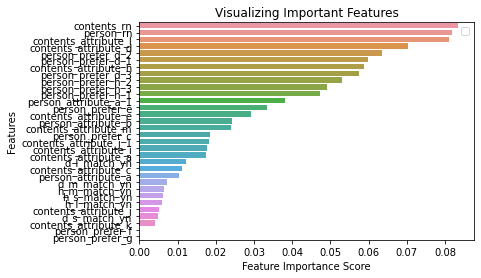

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

그래서 위 요소들 중에 가장 importance 가 낮은것 제외 상위 16개만 학습하면?

In [ ]:
from sklearn.model_selection import train_test_split
# Split dataset into features and labels
X=jobs[['contents_rn', 'person_rn', 'contents_attribute_l',
       'contents_attribute_d', 'person_prefer_d_2', 'person_prefer_d_1',
       'contents_attribute_h', 'person_prefer_d_3', 'person_prefer_h_2',
       'person_prefer_h_3', 'person_prefer_h_1', 'person_attribute_a_1',
       'person_prefer_e', 'contents_attribute_e', 'person_attribute_b',
       'contents_attribute_m']]  # Removed feature "sepal length"
y=jobs['target']                                       
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5) 



In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6007752599853144
